In [ ]:
pip install alibi-detect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.5/381.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_validate, PredefinedSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, make_scorer
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
import os
import sys

# Añadimos la carpeta 'drive' al path
ruta_carpeta_drive = os.path.abspath('../drive') #.. era para salirse de la carpeta actual y entrar en la de drive
if ruta_carpeta_drive not in sys.path:
    sys.path.insert(0, ruta_carpeta_drive)

import drive

# Descargamos los datos en formato parquet de Google Drive
# guardar localmente
drive.descargar_archivos_concretos('train.csv', '../drive')
drive.descargar_archivos_concretos('test.csv', '../drive')

#hay que pasarle la ruta a la carpeta drive desde donde lo estamos ejecutando
# y el nombre del archivo que hemos puesto en el archivos_info.txt (MLP_runs.db en nuestro ejemplo, en vez de datosEntrenamiento.parquet...)
# leer para utilizar esto ya en el modelo
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")
# Filtrar data_train
data_train = data_train[data_train['min_price'] < 100]

# Filtrar data_test
data_test = data_test[data_test['min_price'] < 100]


In [ ]:
data_train

,name,EventStartTime,SalesStartTIme,SalesEndTime,max_price,nameArtist,VenueName,VenueCity,VenueState,num_links,...,Soul,Urban,World,tiene_wiki,tiene_youtube,dias_Venta,dias_desdeFinVenta,num_noches,fold,min_price
0,"30 Aniversario de Sôber, con Savia y Skizoo",2024-03-08 20:00:00+00:00,2023-12-14 11:00:00+00:00,2024-03-08 20:00:00+00:00,28.00,Sober,Live Las Ventas,Madrid,Madrid,1,...,0,0,0,0,0,85,0,1,0,28.00
1,"30 Aniversario de Sôber, con Savia y Skizoo | ...",2024-03-08 20:00:00+00:00,2023-12-14 11:00:00+00:00,2024-03-08 20:00:00+00:00,50.00,Sober,Live Las Ventas,Madrid,Madrid,1,...,0,0,0,0,0,85,0,1,0,50.00
6,Abba The New Experience & Queen Forever,2024-05-29 18:00:00+00:00,2024-02-28 14:00:00+00:00,2024-05-29 18:00:00+00:00,20.00,Abba The New Experience,Zona Camping Circuit Catalunya,Montmeló,Barcelona,0,...,0,0,0,0,0,91,0,1,0,20.00
7,Abraham Mateo y Nil Moliner,2024-08-16 20:00:00+00:00,2024-01-18 11:00:00+00:00,2024-08-14 21:59:00+00:00,57.14,Abraham Mateo,Auditorio Starlite,Marbella,Málaga,9,...,0,0,0,1,1,209,1,1,0,30.01
8,Abraham Mateo y Nil Moliner,2024-04-18 19:00:00+00:00,2023-11-16 11:00:00+00:00,2024-02-21 13:45:00+00:00,58.93,Abraham Mateo,Auditorio Starlite,Marbella,Málaga,9,...,0,0,0,1,1,97,57,1,0,30.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,Yung Sarria,2024-03-30 20:00:00+00:00,2023-10-06 13:00:00+00:00,2024-03-30 20:00:00+00:00,40.00,Yung Sarria,Sala Shoko,Madrid,Madrid,0,...,0,1,0,0,0,176,0,1,3,12.00
490,ZENOBIA + DEBLER,2024-06-01 19:30:00+00:00,2024-02-20 09:00:00+00:00,2024-06-01 19:30:00+00:00,22.00,Zenobia,Sala Shoko,Madrid,Madrid,1,...,0,0,0,0,0,102,0,1,3,22.00
491,gREAT sTRAITS,2024-10-19 19:30:00+00:00,2024-01-02 11:00:00+00:00,2024-10-19 19:30:00+00:00,35.00,gREAT sTRAITS,Sala Razzmatazz 1,Barcelona,Barcelona,0,...,0,0,0,0,0,291,0,1,3,35.00
492,gREAT sTRAITS,2024-09-13 19:30:00+00:00,2023-12-22 09:00:00+00:00,2024-09-13 19:30:00+00:00,75.00,gREAT sTRAITS,La Riviera,Madrid,Madrid,0,...,0,0,0,0,0,266,0,1,3,38.00


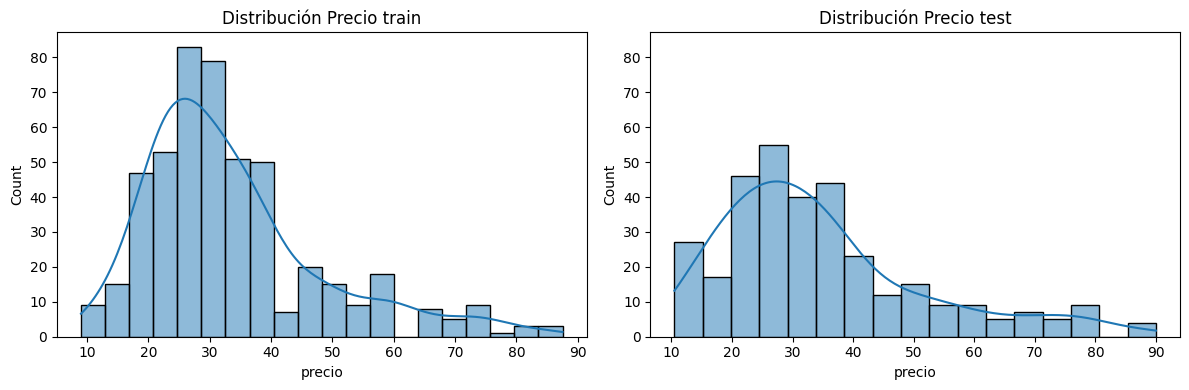

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(data=data_train, x='min_price', kde=True, ax=ax1)
ax1.set_title("Distribución Precio train")
ax1.set_xlabel('precio')

sns.histplot(data=data_test, x='min_price', kde=True, ax=ax2)
ax2.set_title("Distribución Precio test")
ax2.set_xlabel('precio')

# Encontrar el valor máximo de y en ambos gráficos
y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])

# Establecer el mismo límite para ambos ejes y
ax1.set_ylim(0, y_max)
ax2.set_ylim(0, y_max)

plt.tight_layout()
plt.show()

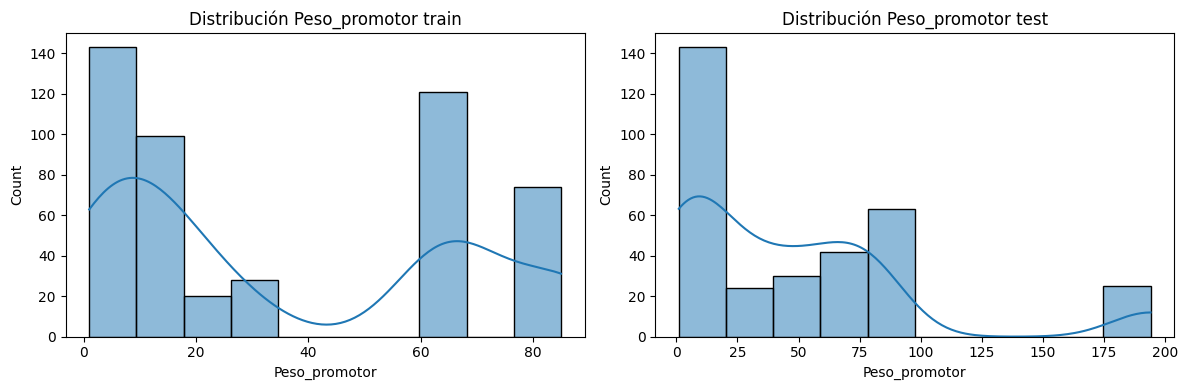

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(data=data_train, x='peso_promotor', kde=True, ax=ax1)
ax1.set_title("Distribución Peso_promotor train")
ax1.set_xlabel('Peso_promotor')

sns.histplot(data=data_test, x='peso_promotor', kde=True, ax=ax2)
ax2.set_title("Distribución Peso_promotor test")
ax2.set_xlabel('Peso_promotor')

# Encontrar el valor máximo de y en ambos gráficos
y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])

# Establecer el mismo límite para ambos ejes y
ax1.set_ylim(0, y_max)
ax2.set_ylim(0, y_max)

plt.tight_layout()
plt.show()

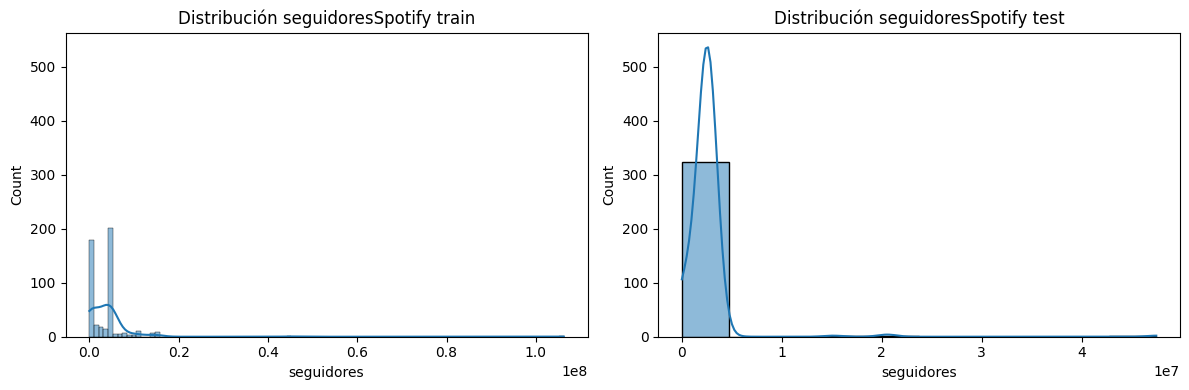

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(data=data_train, x='seguidoresSpotify', kde=True, ax=ax1)
ax1.set_title("Distribución seguidoresSpotify train")
ax1.set_xlabel('seguidores')

sns.histplot(data=data_test, x='seguidoresSpotify', kde=True, ax=ax2)
ax2.set_title("Distribución seguidoresSpotify test")
ax2.set_xlabel('seguidores')

# Encontrar el valor máximo de y en ambos gráficos
y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])

# Establecer el mismo límite para ambos ejes y
ax1.set_ylim(0, y_max)
ax2.set_ylim(0, y_max)

plt.tight_layout()
plt.show()

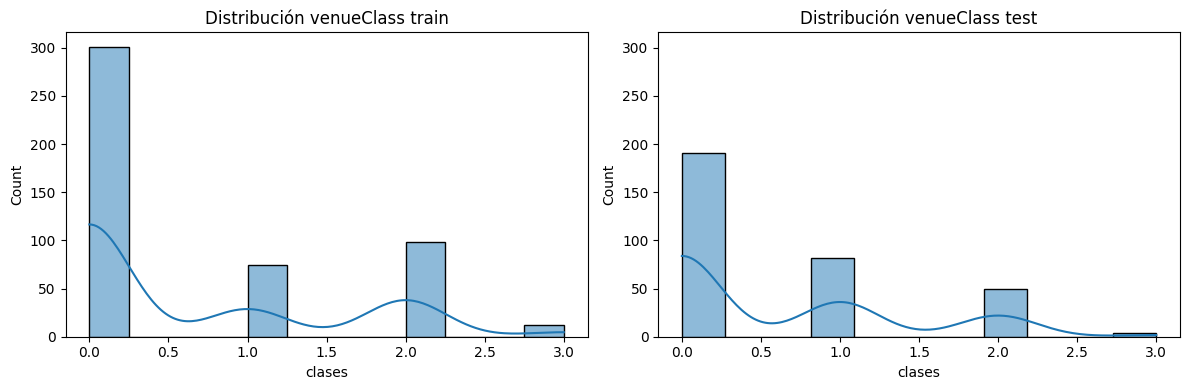

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(data=data_train, x='VenueClass', kde=True, ax=ax1)
ax1.set_title("Distribución venueClass train")
ax1.set_xlabel('clases')

sns.histplot(data=data_test, x='VenueClass', kde=True, ax=ax2)
ax2.set_title("Distribución venueClass test")
ax2.set_xlabel('clases')

# Encontrar el valor máximo de y en ambos gráficos
y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])

# Establecer el mismo límite para ambos ejes y
ax1.set_ylim(0, y_max)
ax2.set_ylim(0, y_max)

plt.tight_layout()
plt.show()

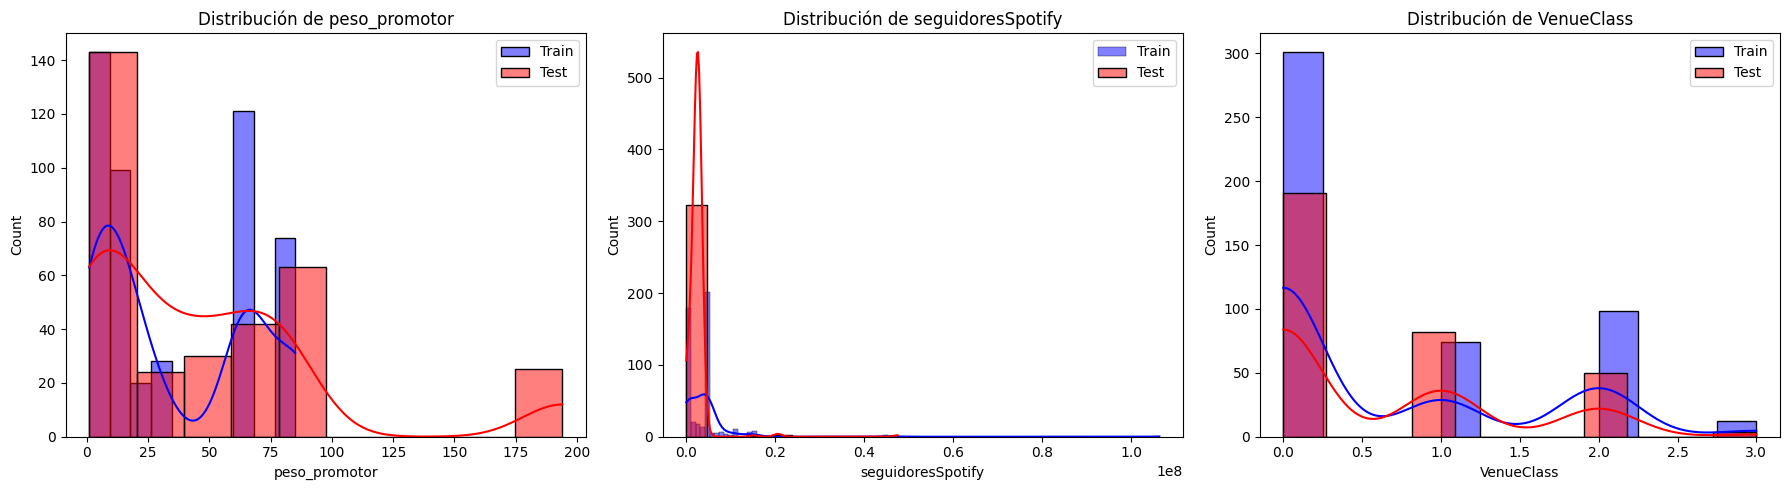

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Variables importantes
variables_importantes = ['peso_promotor', 'seguidoresSpotify', 'VenueClass']

# Crear figura con una única fila
plt.figure(figsize=(18, 5))

for i, var in enumerate(variables_importantes):
    plt.subplot(1, 3, i+1)  # 1 fila y 3 columnas
    sns.histplot(data_train[var], kde=True, color='blue', label='Train')
    sns.histplot(data_test[var], kde=True, color='red', label='Test')
    plt.title(f'Distribución de {var}')
    plt.xlabel(var)
    plt.legend()

plt.tight_layout()
plt.show()


Podemos automatizar el proceso de detección de cambios en las distribuciones utilizando la librería Alibi Detector, que incorpora tests estadísticos como el de Kolmogorov-Smirnov (KS) que usaremos aquí.

Los resultados se interpretan como:
-	**Deriva Detectada**: Un valor True indica que se ha detectado una deriva significativa en los datos de la variable.
-	**P-value**: Un valor pequeño (menor que 0.05) indica que hay evidencia suficiente para rechazar la hipótesis nula de que las dos distribuciones son iguales.
-	**Estadística de la Prueba**: Proporciona una medida de la distancia entre las distribuciones de los datos de entrenamiento y prueba.

Comenzamos con seguidoresSpotify porque se ve que no se mantiene la distribución.

In [ ]:
import numpy as np
from alibi_detect.cd import KSDrift

# Preparar los datos
train_data_spotify = data_train['seguidoresSpotify'].values.reshape(-1, 1)
test_data_spotify = data_test['seguidoresSpotify'].values.reshape(-1, 1)

# Inicializar el detector de deriva
cd = KSDrift(train_data_spotify, p_val=0.05)

# Realizar la detección de deriva en el conjunto de prueba
preds = cd.predict(test_data_spotify)

# Resultados de la detección de deriva
print("Deriva detectada: ", preds['data']['is_drift'])
print("P-value: ", preds['data']['p_val'])
print("Estadística de la prueba: ", preds['data']['distance'])


Deriva detectada:  1
P-value:  [0.]
Estadística de la prueba:  [0.5600366]


- **Deriva detectada: 1**: Esto significa que se ha detectado deriva en los datos.

- **P-value: [0.]**: Un p-valor de 0 indica que hay una diferencia significativa entre las distribuciones de los datos de entrenamiento y prueba. En otras palabras, la probabilidad de que los datos de prueba provengan de la misma distribución que los datos de entrenamiento es extremadamente baja.

- **Estadística de la prueba: [0.5600366]**: Este valor proporciona una medida de la distancia entre las distribuciones de los datos de entrenamiento y prueba. Cuanto mayor sea este valor, mayor es la diferencia entre las distribuciones

Y si lo hacemos ahora para todas las columnas que consideramos más importantes (las numéricas):

In [ ]:
import pandas as pd
from alibi_detect.cd import KSDrift

def check_data_drift(train_data, test_data, feature, p_val=0.05):
    train_data_feature = train_data[feature].dropna().values.reshape(-1, 1)
    test_data_feature = test_data[feature].dropna().values.reshape(-1, 1)

    cd = KSDrift(train_data_feature, p_val=p_val)
    preds = cd.predict(test_data_feature)

    is_drift = preds['data']['is_drift']
    p_value = preds['data']['p_val'][0]
    test_statistic = preds['data']['distance'][0]

    return is_drift, p_value, test_statistic

# columnas numéricas
no_binarias = ['num_links', 'seguidoresSpotify', 'popularidad', 'subsYT', 'NumGeneros', 'peso_promotor',
               'conciertos_del_artista_en_ciudad', 'dias_Venta', 'dias_desdeFinVenta', 'num_noches']

results = {}
for column in no_binarias:
    is_drift, p_value, test_statistic = check_data_drift(data_train, data_test, column)
    results[column] = {'is_drift': is_drift, 'p_value': p_value, 'test_statistic': test_statistic}

# Mostrar resultados
for column, result in results.items():
    if result['is_drift']:
        print(f"Deriva detectada en {column}!")
        print(f"P-value: {result['p_value']}")
        print(f"Estadística de la prueba: {result['test_statistic']}")
    else:
        print(f"No se detectó deriva en {column}.")


Deriva detectada en num_links!
P-value: 2.611622584858253e-10
Estadística de la prueba: 0.23928244411945343
Deriva detectada en seguidoresSpotify!
P-value: 0.0
Estadística de la prueba: 0.5600365996360779
Deriva detectada en popularidad!
P-value: 0.0
Estadística de la prueba: 0.6867114305496216
Deriva detectada en subsYT!
P-value: 0.0
Estadística de la prueba: 0.8515211939811707
Deriva detectada en NumGeneros!
P-value: 1.819094905840481e-17
Estadística de la prueba: 0.312935471534729
Deriva detectada en peso_promotor!
P-value: 7.30546162230894e-05
Estadística de la prueba: 0.1606292724609375
Deriva detectada en conciertos_del_artista_en_ciudad!
P-value: 0.04942616447806358
Estadística de la prueba: 0.09650997817516327
Deriva detectada en dias_Venta!
P-value: 0.006608689669519663
Estadística de la prueba: 0.1200479194521904
No se detectó deriva en dias_desdeFinVenta.
No se detectó deriva en num_noches.


Las únicas que no tienen cambios significativos en la distribución son: dias_desdeFinVenta y num_noches

In [ ]:
# Eliminamos las categoricas
columnas=['name','EventStartTime', 'SalesStartTIme', 'SalesEndTime', 'nameArtist', 'VenueName',
          'VenueCity', 'VenueState','Generos_combinados', 'max_price']

train = data_train.drop(columnas, axis=1)
train = train.drop('fold', axis=1)
test = data_test.drop(columnas, axis=1)

RANDOM_STATE = 83 #fijamos la semilla


In [ ]:
def plot_model_predictions(mlp, X, y, datos1):
    # Entrenar el modelo
    mlp.fit(X, y)
    # Realiza predicciones con el pipeline ajustado
    predicciones = mlp.predict(X)

    # Crea un DataFrame con los precios reales, predichos y el nombre del concierto
    df = pd.DataFrame({'Nombre del Concierto': datos1['name'], 'Precio Real': y, 'Precio Predicho': predicciones})

    # Crea un scatter plot interactivo con Plotly
    fig = px.scatter(df, x='Precio Real', y='Precio Predicho', color='Nombre del Concierto',
                     title='Comparación de Precios Reales vs Precios Predichos',
                     labels={'Precio Real': 'Precio Real', 'Precio Predicho': 'Precio Predicho'})

    # Agrega una línea diagonal que representa la igualdad entre los precios reales y predichos
    fig.add_shape(type='line',
                  x0=df['Precio Real'].min(), y0=df['Precio Real'].min(),
                  x1=df['Precio Real'].max(), y1=df['Precio Real'].max(),
                  line=dict(color='red', width=2, dash='dash'))

    fig.show()

In [ ]:
train

,num_links,seguidoresSpotify,popularidad,subsYT,VenueClass,NumGeneros,peso_promotor,tiene_lastfm_url,conciertos_del_artista_en_ciudad,tiene_twitter,...,Singer-Songwriter,Soul,Urban,World,tiene_wiki,tiene_youtube,dias_Venta,dias_desdeFinVenta,num_noches,min_price
0,1,4.564084e+06,60.904615,1.716398e+06,2,1,22,0,2.0,0,...,0,0,0,0,0,0,85,0,1,28.00
1,1,4.564084e+06,60.904615,1.716398e+06,2,1,22,0,2.0,0,...,0,0,0,0,0,0,85,0,1,50.00
6,0,4.564084e+06,60.904615,1.716398e+06,1,1,2,0,1.0,0,...,0,0,0,0,0,0,91,0,1,20.00
7,9,4.564084e+06,60.904615,1.716398e+06,0,1,65,1,2.0,1,...,0,0,0,0,1,1,209,1,1,30.01
8,9,4.564084e+06,60.904615,1.716398e+06,0,1,65,1,2.0,1,...,0,0,0,0,1,1,97,57,1,30.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,0,4.564084e+06,60.904615,1.716398e+06,0,1,3,0,1.0,0,...,0,0,1,0,0,0,176,0,1,12.00
490,1,4.564084e+06,60.904615,1.716398e+06,0,1,8,0,1.0,0,...,0,0,0,0,0,0,102,0,1,22.00
491,0,4.564084e+06,60.904615,1.716398e+06,0,1,2,0,1.0,0,...,0,0,0,0,0,0,291,0,1,35.00
492,0,4.564084e+06,60.904615,1.716398e+06,1,1,2,0,1.0,0,...,0,0,0,0,0,0,266,0,1,38.00


In [ ]:
# Definir la variable objetivo y las características
y_train = train['min_price']
X_train = train.drop('min_price', axis=1)

# Definir la variable objetivo y las características
y_test = test['min_price']
X_test = test.drop('min_price', axis=1)

In [ ]:
X_test['New Wave']=0
X_test['Performance Art']=0

In [ ]:
len(X_train.columns)

56

In [ ]:
len(X_test.columns)

56

In [ ]:
X_train

,num_links,seguidoresSpotify,popularidad,subsYT,VenueClass,NumGeneros,peso_promotor,tiene_lastfm_url,conciertos_del_artista_en_ciudad,tiene_twitter,...,Rock,Singer-Songwriter,Soul,Urban,World,tiene_wiki,tiene_youtube,dias_Venta,dias_desdeFinVenta,num_noches
0,1,4.564084e+06,60.904615,1.716398e+06,2,1,22,0,2.0,0,...,1,0,0,0,0,0,0,85,0,1
1,1,4.564084e+06,60.904615,1.716398e+06,2,1,22,0,2.0,0,...,1,0,0,0,0,0,0,85,0,1
6,0,4.564084e+06,60.904615,1.716398e+06,1,1,2,0,1.0,0,...,1,0,0,0,0,0,0,91,0,1
7,9,4.564084e+06,60.904615,1.716398e+06,0,1,65,1,2.0,1,...,0,0,0,0,0,1,1,209,1,1
8,9,4.564084e+06,60.904615,1.716398e+06,0,1,65,1,2.0,1,...,0,0,0,0,0,1,1,97,57,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,0,4.564084e+06,60.904615,1.716398e+06,0,1,3,0,1.0,0,...,0,0,0,1,0,0,0,176,0,1
490,1,4.564084e+06,60.904615,1.716398e+06,0,1,8,0,1.0,0,...,1,0,0,0,0,0,0,102,0,1
491,0,4.564084e+06,60.904615,1.716398e+06,0,1,2,0,1.0,0,...,1,0,0,0,0,0,0,291,0,1
492,0,4.564084e+06,60.904615,1.716398e+06,1,1,2,0,1.0,0,...,1,0,0,0,0,0,0,266,0,1


In [ ]:
X_test = X_test[X_train.columns]
X_test

,num_links,seguidoresSpotify,popularidad,subsYT,VenueClass,NumGeneros,peso_promotor,tiene_lastfm_url,conciertos_del_artista_en_ciudad,tiene_twitter,...,Rock,Singer-Songwriter,Soul,Urban,World,tiene_wiki,tiene_youtube,dias_Venta,dias_desdeFinVenta,num_noches
0,7,2.572597e+06,56.162602,2.591877e+06,2,1,2,1,2.0,1,...,1,0,0,0,0,1,1,171,0,2
1,7,2.817062e+06,75.000000,2.890000e+06,2,2,7,0,1.0,1,...,1,0,0,0,0,0,1,364,0,1
2,3,2.572597e+06,56.162602,2.591877e+06,1,1,2,0,1.0,0,...,1,0,0,0,1,1,0,212,0,1
3,9,2.572597e+06,56.162602,2.591877e+06,2,1,2,1,2.0,1,...,1,0,0,0,1,1,1,215,0,1
4,0,2.572597e+06,56.162602,2.591877e+06,1,1,3,0,1.0,0,...,1,0,0,0,0,0,0,237,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,0,2.572597e+06,56.162602,2.591877e+06,2,1,4,0,1.0,0,...,0,0,0,0,0,0,0,187,0,1
332,0,2.572597e+06,56.162602,2.591877e+06,2,1,1,0,1.0,0,...,0,0,0,0,0,0,0,211,0,1
333,0,2.572597e+06,56.162602,2.591877e+06,2,1,5,0,1.0,0,...,1,0,0,0,0,0,0,197,0,1
334,0,2.572597e+06,56.162602,2.591877e+06,0,1,1,0,1.0,0,...,0,0,0,0,0,0,0,198,0,1


In [ ]:
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de y_train:", y_train.shape)

Dimensiones de X_train: (485, 56)
Dimensiones de y_train: (485,)


In [ ]:
print("Dimensiones de X_test:", X_test.shape)
print("Dimensiones de y_test:", y_test.shape)


Dimensiones de X_test: (327, 56)
Dimensiones de y_test: (327,)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Definir el modelo RandomForestRegressor con los hiperparámetros dados
modelo_rf = RandomForestRegressor(n_estimators=50,
                                  min_samples_split=5,
                                  min_samples_leaf=2,
                                  max_depth=35,
                                  random_state=RANDOM_STATE)

# Entrenar el modelo
modelo_rf.fit(X_train, y_train)
# Predecir en el conjunto de entrenamiento
y_pred_train = modelo_rf.predict(X_train)

# Calcular métricas sobre el conjunto de entrenamiento
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
mae_train = mean_absolute_error(y_train, y_pred_train)

print("Métricas sobre el conjunto de entrenamiento:")
print("MAPE Train:", mape_train)
print("RMSE Train:", rmse_train)
print("MAE Train:", mae_train)

# Predecir en el conjunto de prueba
y_pred_test = modelo_rf.predict(X_test)

# Calcular métricas sobre el conjunto de prueba
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mae_test = mean_absolute_error(y_test, y_pred_test)

print("\nMétricas sobre el conjunto de prueba:")
print("MAPE Test:", mape_test)
print("RMSE Test:", rmse_test)
print("MAE Test:", mae_test)


Métricas sobre el conjunto de entrenamiento:
MAPE Train: 0.08577118018473065
RMSE Train: 4.722682659983263
MAE Train: 2.841873032698115

Métricas sobre el conjunto de prueba:
MAPE Test: 0.29699754080496754
RMSE Test: 15.668199321801186
MAE Test: 10.685436609073903


In [ ]:
# Definir el modelo con los parámetros específicos o los mejores encontrados
best_model_random = RandomForestRegressor(n_estimators=50,
                                          min_samples_split=5,
                                          min_samples_leaf=2,
                                          max_depth=35,
                                          random_state=RANDOM_STATE)  # Ajusta la semilla aleatoria según sea necesario

# Entrenar el modelo con los datos de entrenamiento
best_model_random.fit(X_train, y_train)
# Realizar predicciones en el conjunto de prueba
predicciones = best_model_random.predict(X_test)

# Crear DataFrame con los precios reales, predichos y el nombre del concierto
df_predicciones = pd.DataFrame({
    'Nombre del Concierto': data_test['name'],
    'Precio Real': y_test,
    'Precio Predicho': predicciones
})
# Crear scatter plot interactivo con Plotly
fig = px.scatter(df_predicciones, x='Precio Real', y='Precio Predicho', color='Nombre del Concierto',
                 title='Comparación de Precios Reales vs Precios Predichos (Random Forest)',
                 labels={'Precio Real': 'Precio Real', 'Precio Predicho': 'Precio Predicho'})

# Agregar una línea diagonal que representa la igualdad entre los precios reales y predichos
fig.add_shape(type='line',
              x0=df_predicciones['Precio Real'].min(), y0=df_predicciones['Precio Real'].min(),
              x1=df_predicciones['Precio Real'].max(), y1=df_predicciones['Precio Real'].max(),
              line=dict(color='red', width=2, dash='dash'))

# Mostrar el gráfico interactivo
fig.show()


In [ ]:
def rmse_with_respect_to_median(predictions, actuals):
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    median_actuals = np.median(actuals)
    squared_errors = (predictions - median_actuals) ** 2
    mse = np.mean(squared_errors)
    rmse = np.sqrt(mse)
    return rmse

def mape_with_respect_to_median(predictions, actuals):
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    median_actuals = np.median(actuals)
    percentage_errors = np.abs(predictions - median_actuals) / median_actuals
    mape = np.mean(percentage_errors) * 100
    return mape


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import plotly.express as px
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import median_absolute_error
# Definir el modelo con los parámetros específicos o los mejores encontrados
best_model_random = RandomForestRegressor(n_estimators=50,
                                          min_samples_split=5,
                                          min_samples_leaf=2,
                                          max_depth=35,
                                          random_state=RANDOM_STATE)

# Entrenar el modelo con los datos de entrenamiento
best_model_random.fit(X_train, y_train)

# Realizar predicciones en el conjunto de entrenamiento
y_train_pred = best_model_random.predict(X_train)

# Calcular métricas sobre el conjunto de entrenamiento
metrics_train = {
    'MedAE': median_absolute_error(y_train, y_train_pred),
    'MedAPE': mape_with_respect_to_median(y_train_pred, y_train),
    'MedRMSE': rmse_with_respect_to_median(y_train_pred, y_train),
    'MAPE': mean_absolute_percentage_error(y_train, y_train_pred),
    'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred))
}

# Realizar predicciones en el conjunto de prueba
y_test_pred = best_model_random.predict(X_test)

# Calcular las métricas para el conjunto de prueba
metrics_test = {
    'MedAE': median_absolute_error(y_test, y_test_pred),
    'MedAPE': mape_with_respect_to_median(y_test_pred, y_test),
    'MedRMSE': rmse_with_respect_to_median(y_test_pred, y_test),
    'MAPE': mean_absolute_percentage_error(y_test, y_test_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred))
}

# Imprimir los resultados de las métricas para el conjunto de entrenamiento
print("Métricas para el conjunto de entrenamiento:")
for metric_name, metric_value in metrics_train.items():
    print(f"{metric_name}: {metric_value:.4f}")

# Imprimir los resultados de las métricas para el conjunto de prueba
print("\nMétricas para el conjunto de prueba:")
for metric_name, metric_value in metrics_test.items():
    print(f"{metric_name}: {metric_value:.4f}")

# Crear DataFrame con los precios reales, predichos, desviación y el nombre del concierto
df_predicciones = pd.DataFrame({
    'Nombre del Concierto': data_test['name'],
    'Precio Real': y_test,
    'Precio Predicho': y_test_pred,
    'Desviación Absoluta': np.abs(y_test - y_test_pred)
})

# Crear scatter plot interactivo con Plotly
fig = px.scatter(df_predicciones, x='Precio Real', y='Precio Predicho', color='Desviación Absoluta',
                 title='Comparación de Precios Reales vs Precios Predichos (Random Forest)',
                 labels={'Precio Real': 'Precio Real', 'Precio Predicho': 'Precio Predicho'},
                 hover_data=['Nombre del Concierto', 'Desviación Absoluta'])

# Agregar una línea diagonal que representa la igualdad entre los precios reales y predichos
fig.add_shape(type='line',
              x0=df_predicciones['Precio Real'].min(), y0=df_predicciones['Precio Real'].min(),
              x1=df_predicciones['Precio Real'].max(), y1=df_predicciones['Precio Real'].max(),
              line=dict(color='red', width=2, dash='dash'))

# Mostrar el gráfico interactivo
fig.show()


Métricas para el conjunto de entrenamiento:
MedAE: 1.4455
MedAPE: 32.3149
MedRMSE: 13.6288
MAPE: 0.0858
RMSE: 4.7227

Métricas para el conjunto de prueba:
MedAE: 6.8937
MedAPE: 18.9753
MedRMSE: 7.3872
MAPE: 0.2970
RMSE: 15.6682


In [ ]:
data_test['VenueClass'].unique()

array([2, 1, 3, 0])


Características más importantes del modelo:
popularidad: 0.3047700341302792
seguidoresSpotify: 0.14181227194099333
VenueClass: 0.09743488190688797
conciertos_del_artista_en_ciudad: 0.09007096388095526
peso_promotor: 0.07093606631529674
dias_Venta: 0.061310071612989
NumGeneros: 0.04234923827135604
Latin: 0.028094559144458815
num_links: 0.02484906310798673
tiene_homepage: 0.02126748461961421


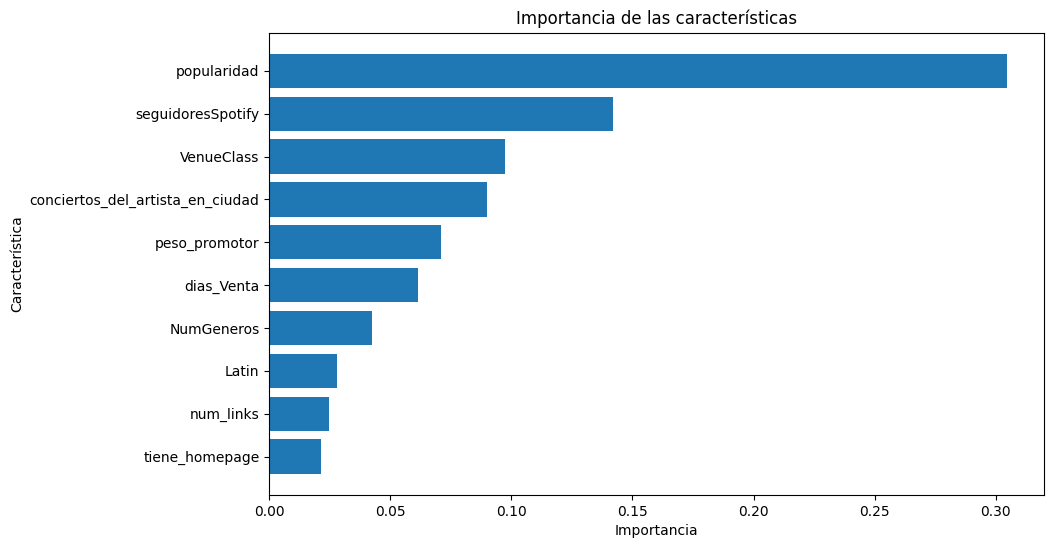

In [ ]:
# Importancia de las características
feature_importance_random = best_model_random.feature_importances_
top_indices_random = np.argsort(feature_importance_random)[::-1][:10]

print("\nCaracterísticas más importantes del modelo:")
for i in top_indices_random:
    print(f"{X_test.columns[i]}: {feature_importance_random[i]}")

# Crear un DataFrame para las importancias de las características
df_feature_importance = pd.DataFrame({
    'Característica': X_test.columns[top_indices_random],
    'Importancia': feature_importance_random[top_indices_random]
})

# Visualizar las características más importantes
plt.figure(figsize=(10, 6))
plt.barh(df_feature_importance['Característica'], df_feature_importance['Importancia'])
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.title('Importancia de las características')
plt.gca().invert_yaxis()
plt.show()

   VenueClass       rmse      mape
0           2  13.989717  0.254822
1           1  21.712936  0.337097
2           3  13.328418  0.196747
3           0  12.764646  0.292922


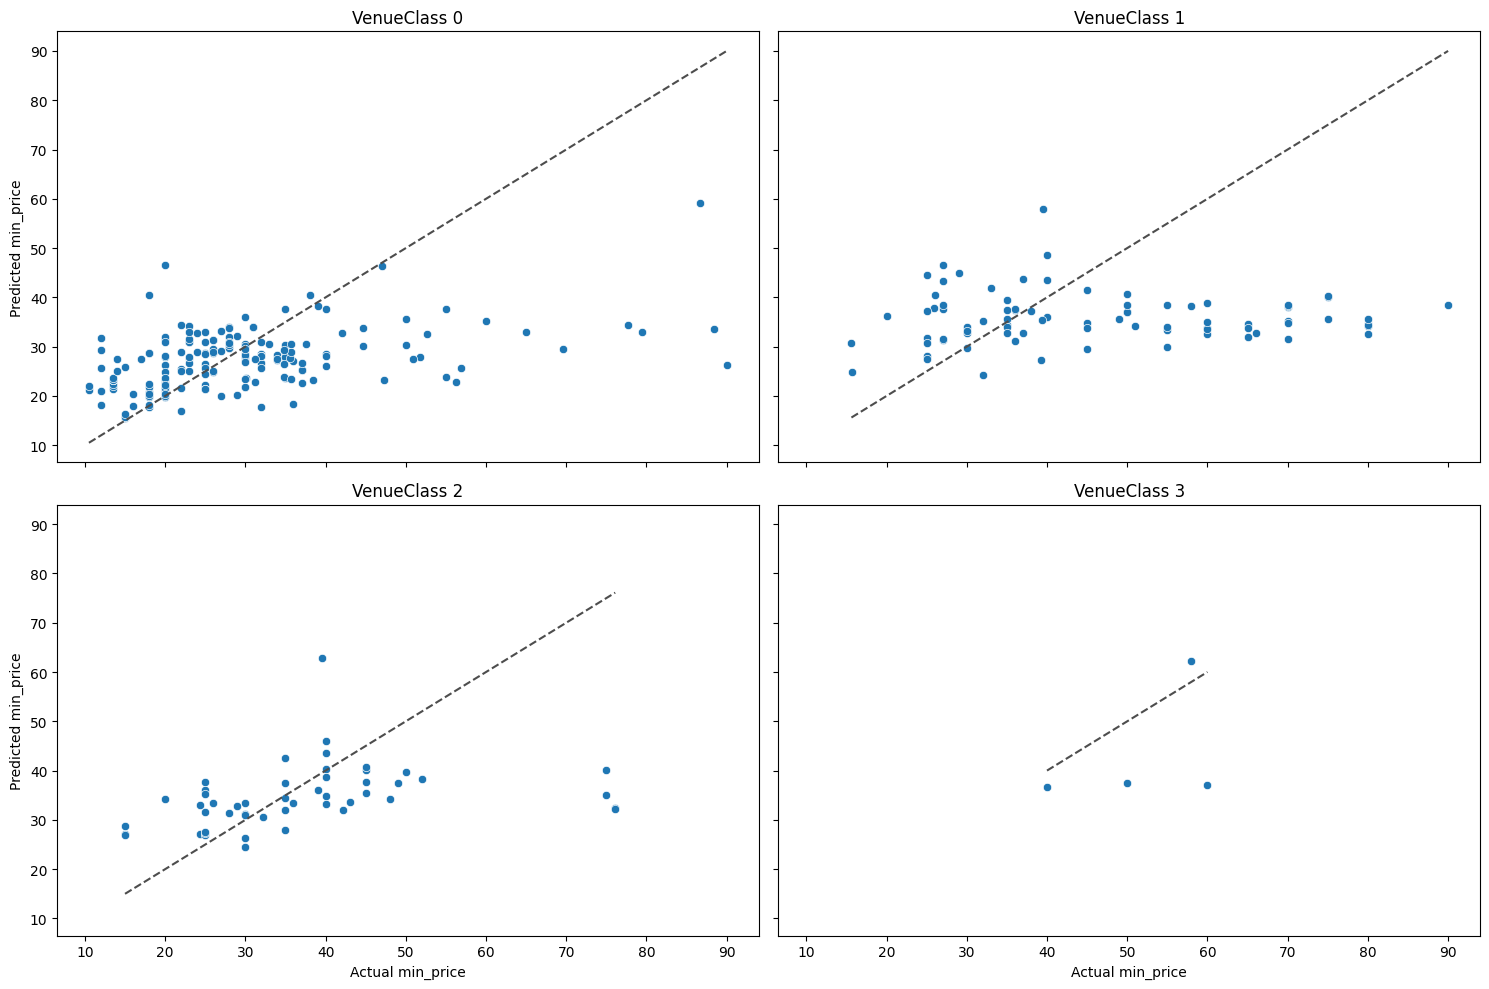

In [ ]:

# Copiar el DataFrame original
datos_segmentos = data_test.copy()
# Añadir las predicciones al DataFrame
datos_segmentos['pred'] = y_test_pred

# Lista para almacenar los resultados
resultados_list = []

# Calcular las métricas para cada valor de "VenueClass"
for vc in datos_segmentos['VenueClass'].unique():
    subset = datos_segmentos[datos_segmentos['VenueClass'] == vc]
    mse = mean_squared_error(subset['min_price'], subset['pred'])
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(subset['min_price'], subset['pred'])
    resultados_list.append({'VenueClass': vc, 'rmse': rmse, 'mape': mape})

# Convertir la lista de resultados en un DataFrame
resultados = pd.DataFrame(resultados_list)
print(resultados)

# Configurar la figura y los ejes
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

# Ordenar los datos
venue_classes = sorted(datos_segmentos['VenueClass'].unique())

# Generar gráficos de dispersión para cada "VenueClass"
for idx, vc in enumerate(venue_classes):
    subset = datos_segmentos[datos_segmentos['VenueClass'] == vc]
    ax = axes[idx//2, idx%2]  # Ubicación del gráfico en la cuadrícula
    sns.scatterplot(ax=ax, x=subset['min_price'], y=subset['pred'])
    ax.plot([subset['min_price'].min(), subset['min_price'].max()],
            [subset['min_price'].min(), subset['min_price'].max()],
            ls="--", c=".3")
    ax.set_title(f'VenueClass {vc}')
    ax.set_xlabel('Actual min_price')
    ax.set_ylabel('Predicted min_price')

plt.tight_layout()
plt.show()


**Heuristica**

In [ ]:
min_price_mean_by_venue_class_train = data_train.groupby('VenueClass')['min_price'].mean()
min_price_mean_by_venue_class_train

VenueClass
0    28.828372
1    38.450000
2    42.520000
3    53.035833
Name: min_price, dtype: float64

In [ ]:
data_test['min_price_pred'] = y_test_pred  # Agregar las predicciones al DataFrame data_test


In [ ]:
data_test['MinPrice Real Medio'] = data_test['VenueClass'].map(min_price_mean_by_venue_class_train)


In [ ]:
data_test['Diferencia Predicción vs Real Medio'] = data_test['min_price_pred'] - data_test['MinPrice Real Medio']


In [ ]:
media_diferencia_por_evento = data_test.groupby('VenueClass')['Diferencia Predicción vs Real Medio'].mean()

print("Media de la diferencia entre Predicción y Real Medio por Tipo de Evento:")
print(media_diferencia_por_evento)

Media de la diferencia entre Predicción y Real Medio por Tipo de Evento:
VenueClass
0   -1.830660
1   -2.558780
2   -7.973875
3   -9.684451
Name: Diferencia Predicción vs Real Medio, dtype: float64


In [ ]:
import plotly.express as px

# Crear una gráfica para cada tipo de venue_class (asegúrate de usar el nombre correcto de la columna)
fig = px.scatter(data_test, x='MinPrice Real Medio', y='min_price_pred', color='VenueClass',
                 title='Comparación de Precios Predichos vs Precios Medios Reales por Tipo de Evento',
                 labels={'MinPrice Real Medio': 'Precio Medio Real', 'min_price_pred': 'Precio Predicho'},
                 hover_data=['Diferencia Predicción vs Real Medio'])

# Agregar una línea diagonal que representa la igualdad entre los precios medios reales y los predichos
fig.add_shape(type='line',
              x0=data_test['MinPrice Real Medio'].min(), y0=data_test['MinPrice Real Medio'].min(),
              x1=data_test['MinPrice Real Medio'].max(), y1=data_test['MinPrice Real Medio'].max(),
              line=dict(color='red', width=2, dash='dash'))

# Mostrar el gráfico interactivo
fig.show()
